In [ ]:

from graphviz import Digraph
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  

  def sigmoid(self):
    x = self.data
    t = 1 / (1 + math.exp(-x))
    out = Value(t, (self,), 'sigmoid')

    def _backward():
        self.grad += (t * (1 - t)) * out.grad
    out._backward = _backward

    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
# Input x1, x2, x3
x1 = Value(0.7, label = 'x1')
x2 = Value(0.8, label = 'x2')
x3 = Value(0.9, label = 'x3')

# Weight w14, w15, w24, w25, w34, w35, w46, w56
w14 = Value(0.5, label = 'w14')
w15 = Value(0.6, label = 'w15')
w24 = Value(0.3, label = 'w24')
w25 = Value(1.1, label = 'w25')
w34 = Value(-1.0, label = 'w34')
w35 = Value(0.1, label = 'w35')
w46 = Value(-1.1, label = 'w46')
w56 = Value(-0.7, label = 'w56')

# threshold and theta
th = Value(-1.0, label ='threshold')
th4 = Value(0.2, label = 'th4')
th5 = Value(0.3, label = 'th5')
th6 = Value(0.4, label = 'th6')

y_true = Value(0.0, label = 'y_true')

In [ ]:
# forward 

x1w14 = x1*w14; x1w14.label = 'x1w14'
x1w15 = x1*w15; x1w15.label = 'x1w15'
x2w24 = x2*w24; x2w24.label = 'x2w24'
x2w25 = x2*w25; x2w25.label = 'x2w25'
x3w34 = x3*w34; x3w34.label = 'x3w34'
x3w35 = x3*w35; x3w35.label = 'x3w35'

b4 = th*th4; b4.label = 'b4'
b5 = th*th5; b5.label = 'b5'
b6 = th*th6; b6.label = 'b6'

x4 = x1w14 + x2w24 + x3w34 + b4; x4.label = 'x4'
y4 = x4.sigmoid(); y4.label = 'y4'

x5 = x1w15 + x2w25 + x3w35 + b5; x5.label = 'x5'
y5 = x5.sigmoid(); y5.label = 'y5'

x6 = y4*w46 + y5*w56 + b6; x6.label = 'x6'
y6 = x6.sigmoid(); y6.label = 'y6'

Loss = y_true - y6; Loss.label = 'L'

In [ ]:
# Forward 
draw_dot(Loss)

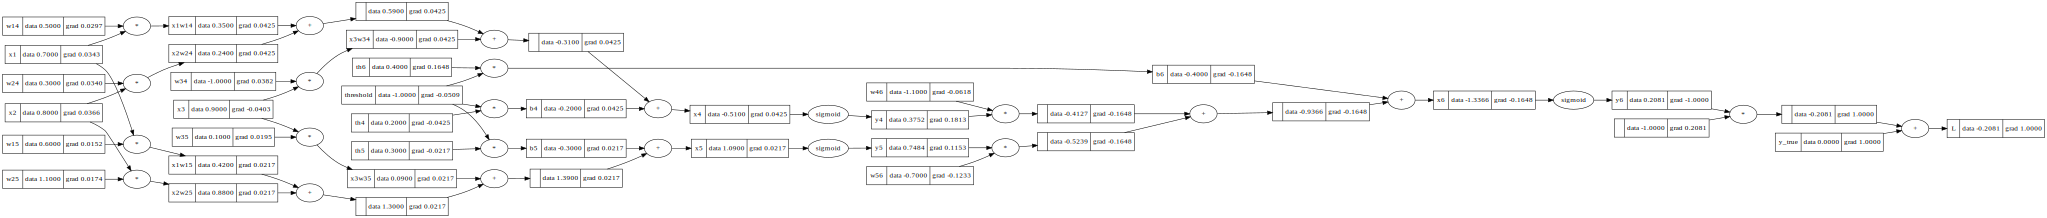

In [ ]:
# backward
Loss.backward()
draw_dot(Loss)

In [ ]:
# Input x1, x2, x3
x1 = Value(0.7, label = 'x1')
x2 = Value(0.8, label = 'x2')
x3 = Value(0.9, label = 'x3')

# Weight w14, w15, w24, w25, w34, w35, w46, w56
w14 = Value(0.5, label = 'w14')
w15 = Value(0.6, label = 'w15')
w24 = Value(0.3, label = 'w24')
w25 = Value(1.1, label = 'w25')
w34 = Value(-1.0, label = 'w34')
w35 = Value(0.1, label = 'w35')
w46 = Value(-1.1, label = 'w46')
w56 = Value(-0.7, label = 'w56')

# threshold and theta
# th = Value(-1.0, label ='threshold')
th4 = Value(0.2, label = 'th4')
th5 = Value(0.3, label = 'th5')
th6 = Value(0.4, label = 'th6')

y_true = Value(0.0, label = 'y_true')

In [ ]:
n4 = (x1*w14 + x2*w24 + x3*w34 - th4).sigmoid()
n5 = (x1*w15 + x2*w25 + x3*w35 - th5).sigmoid()
n6 = (n4*w46 + n5*w56 - th6).sigmoid()
L = y_true - n6

In [ ]:
draw_dot(L)

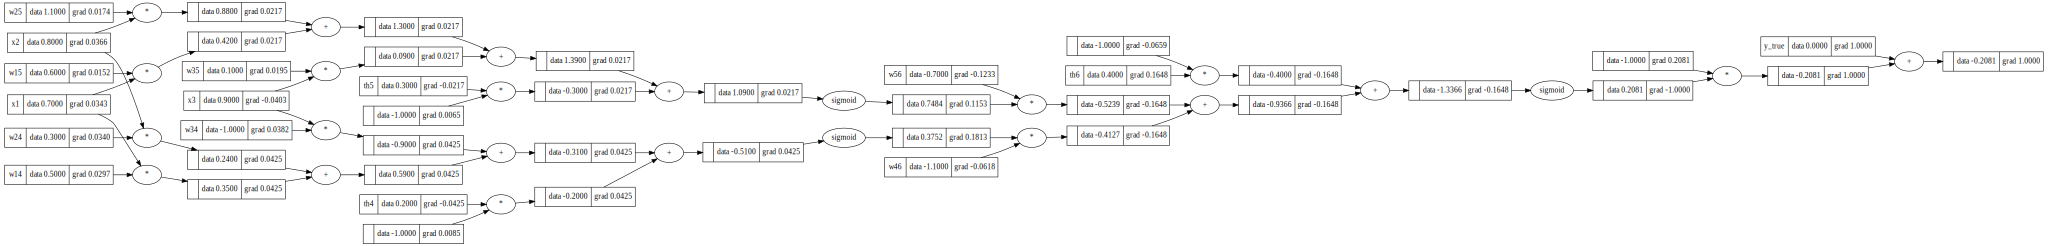

In [ ]:
L.backward()
draw_dot(L)

## Coba Kasus Pada Materi Chapter 8.2

In [ ]:
# Test kasus pada slide

# Input a1, a2
a1 = Value(1.0, label = 'a1')
a2 = Value(1.0, label = 'a2')

w13 = Value(0.5, label = 'w13')
w23 = Value(0.4, label = 'w23')

w14 = Value(0.9, label = 'w14')
w24 = Value(1.0, label = 'w24')

w35 = Value(-1.2, label = 'w35')
w45 = Value(1.1, label = 'w45')

t3 = Value(0.8, label ='t3')
t4 = Value(-0.1, label ='t4')
t5 = Value(0.3, label ='t5')

y5_true = Value(0, label= 'y5_true')

In [ ]:
a3 = (a1*w13 + a2*w23 - t3).sigmoid()
a4 = (a1*w14 + a2*w24 - t4).sigmoid()

a5 = (a3*w35 + a4*w45 - t5).sigmoid()

ER = y5_true - a5

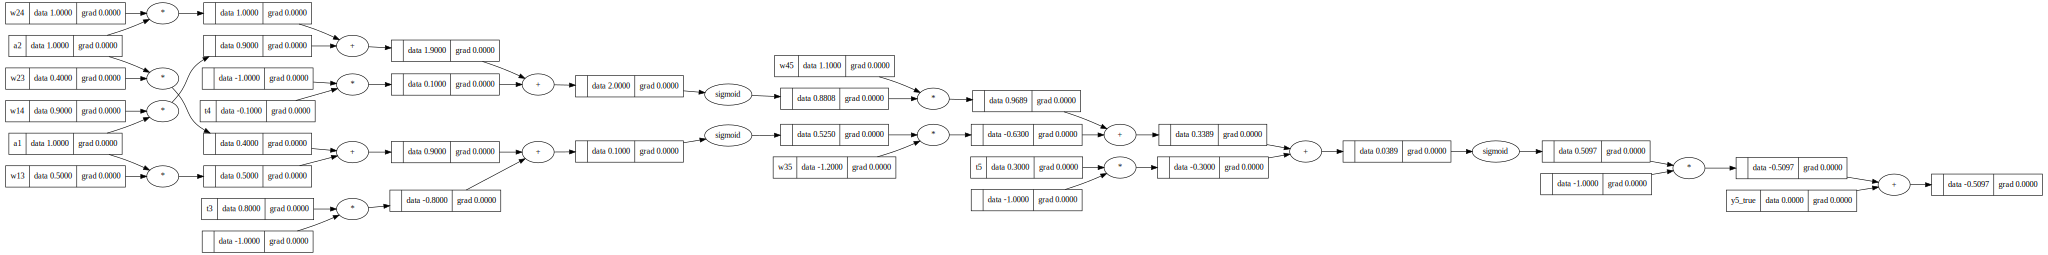

In [ ]:
draw_dot(ER)

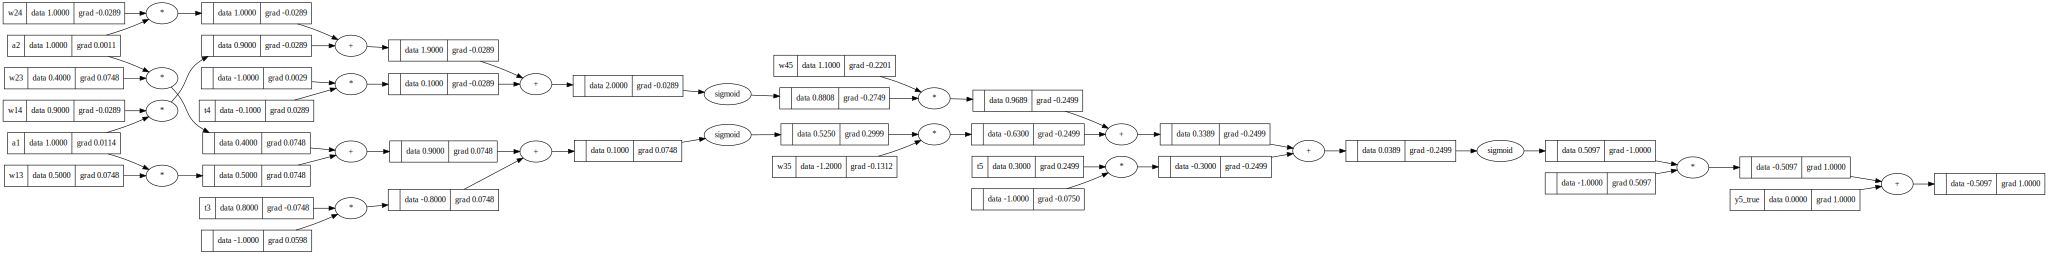

In [ ]:
ER.backward()
draw_dot(ER)